# The STATS NetCDF files

How to use Xarray with the -STATS.nc NetCDF files

In [1]:
import pyopia.statistics
import pyopia.pipeline
import pyopia.io

## Loading processed data from disc using Xarray

This is data that would normally be written by {func}`pyopia.io.make_xstats` or at the end of a processing pipeline (see {class}`pyopia.pipeline.Pipeline`)

In [2]:
xstats = pyopia.io.load_stats('test-STATS.nc')
xstats

<xarray.Dataset>
Dimensions:                     (index: 15660)
Coordinates:
  * index                       (index) int32 0 1 2 3 4 ... 865 866 867 868 869
    time                        (index) datetime64[ns] 2018-11-01T14:27:31.83...
Data variables: (12/17)
    export name                 (index) object 'D20181101T142731.838206-PN0' ...
    major_axis_length           (index) float64 6.176 15.52 21.23 ... 6.34 5.779
    minor_axis_length           (index) float64 2.744 13.09 ... 4.598 2.874
    equivalent_diameter         (index) float64 3.909 14.14 ... 5.412 4.068
    minr                        (index) float64 3.0 3.0 ... 2.033e+03 2.037e+03
    minc                        (index) float64 77.0 1.896e+03 ... 1.754e+03
    ...                          ...
    probability_faecal_pellets  (index) float64 0.004881 2.016e-06 ... 2.448e-06
    probability_copepod         (index) float64 0.003022 7.33e-06 ... 7.925e-07
    probability_diatom_chain    (index) float64 0.004415 2.536e-06 ... 2.966e-06
    probability_oily_gas        (index) float64 0.106 0.0222 ... 1.357e-05
    timestamp                   (index) datetime64[ns] 2018-11-01T14:27:31.83...
    saturation                  (index) float64 21.67 21.67 ... 21.67 21.67
Attributes:
    steps:           [general]\nraw_files = "raw_data/*.silc"\npixel_size = 2...
    Modified:        2024-08-09 07:59:40.392013
    PyOpia version:  1.1.4

## Access the settings used to process the data

This is metada contained within the 'steps' attribute. {func}`pyopia.pipeline.steps_from_xstats` can extract this from the xarray for you:

In [3]:
toml_steps = pyopia.pipeline.steps_from_xstats(xstats)
toml_steps

{'general': {'raw_files': 'raw_data/*.silc', 'pixel_size': 24},
 'steps': {'classifier': {'pipeline_class': 'pyopia.classify.Classify',
   'model_path': 'keras_model.h5'},
  'load': {'pipeline_class': 'pyopia.instrument.silcam.SilCamLoad'},
  'imageprep': {'pipeline_class': 'pyopia.instrument.silcam.ImagePrep',
   'image_level': 'imraw'},
  'segmentation': {'pipeline_class': 'pyopia.process.Segment',
   'threshold': 0.85},
  'statextract': {'pipeline_class': 'pyopia.process.CalculateStats'},
  'output': {'pipeline_class': 'pyopia.io.StatsToDisc',
   'output_datafile': './test'}}}

You can use this to modify settings, or re-process a dataset using {class}`pyopia.pipeline.Pipeline`

Or you might want to access some other metadata, such as pixel size, for use in analysis:

In [4]:
toml_steps['general']['pixel_size']

24

We can plot directly from xarray in exactly the same way as from the Pandas DataFrame (so it doesn't matter which you use here). The benefit of 'xstats' as an xarray is that it now contains it's own metadata

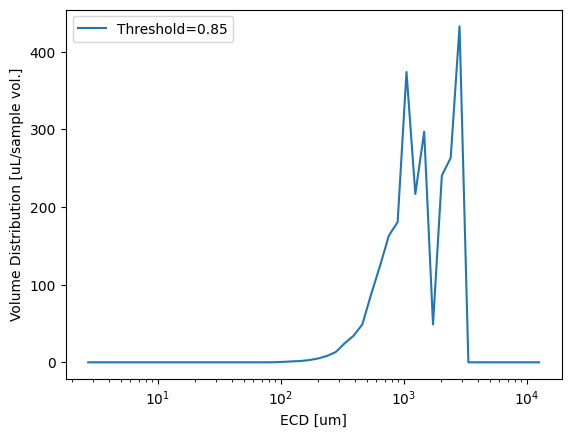

In [5]:
import matplotlib.pyplot as plt

dias, vd = pyopia.statistics.vd_from_stats(xstats, toml_steps['general']['pixel_size'])

plt.plot(dias, vd, label=f"Threshold={toml_steps['steps']['segmentation']['threshold']}")
plt.xscale('log')
plt.xlabel('ECD [um]')
plt.ylabel('Volume Distribution [uL/sample vol.]')
plt.legend()
plt.show()

(big-data)=
## Big datasets

When processing, use the non-appending functionality in {class}`pyopia.io.StatsToDisc`

```
    [steps.output]
    pipeline_class = 'pyopia.io.StatsToDisc'
    output_datafile = 'proc/test' # prefix path for output nc file
    append = false
```

Using the above output step in you pipeline will create a directory 'proc' filled with nc files conforming to the pattern: 'test-Image-D*-STATS.nc'

These can be combined into one file like this:

```python
xstats, image_stats = pyopia.io.combine_stats_netcdf_files('proc/')
```

And the make a new nc file of the whole dataset for faster loading later:

```python
settings = pyopia.pipeline.steps_from_xstats(xstats)

pyopia.io.write_stats(xstats.to_dataframe(),
                      'proc/test2-test',
                      settings,
                      image_stats=image_stats.to_dataframe())

xstats = pyopia.io.load_stats('proc/test2-test-STATS.nc')
```